In [1]:
import numpy as np
from oracle import Oracle
from accuracy_test import accuracy_check

In [2]:
def decentralizedSGD(x0, lr, max_iter, W, oracle):
    
    x_t = x0
    
    x_store = np.zeros((max_iter, x0.shape[0], x0.shape[1]))
    
    for t in range(max_iter):
         
        noise = np.random.normal(0, 1, size=x_t.shape)
        
        f, df = oracle(x_t + noise)
        
        y_t = x_t - lr * df
        x_t = np.matmul(y_t, W)
        
        x_store[t, :, :] = x_t
        
    return x_store

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = min(1 / (degrees[i] + 1), 1 / (degrees[j] + 1))
                
                W[i, j] = weight
                W[j, i] = weight
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            W[i, i] = 0
            
        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [0]
            else:
                connections[node] = [node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        for node in range(1, n_nodes):
            connections[node] = [0] # node 0 is central node
            
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(n_nodes, n_params, topology, func_type, max_iter, lr):
    
    x0 = np.random.randn(n_params, n_nodes)
    W = buildTopology(n_nodes, topology)
    oracle = Oracle(func_type, n_params, n_nodes)
    
    x_store = decentralizedSGD(x0, lr, max_iter, W, oracle)
    
    x_star = oracle.getMin()
    f_star, _ = oracle(x_star)
    
    mu = -1 if (func_type != "strongly convex") else 1
    
    accuracy_check(func_type, x_store, oracle, x_star, f_star, mu, W)
    

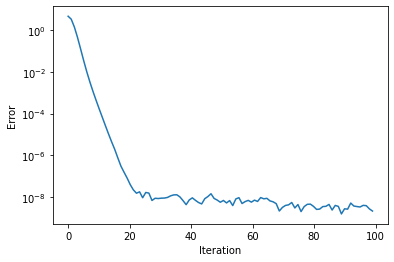

In [3]:
n_nodes = 4
n_params = 6
topology = "ring"
func_type = "strongly convex"
max_iter = 100
lr = 1e-4


experiment(n_nodes, n_params, topology, func_type, max_iter, lr)